In [10]:
import pycaret
import pandas as pd

In [11]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/export-pm25_eng-1d.csv')

In [12]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [13]:
data.tail()

,Unnamed: 0,timezone,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature
timestamp,,,,,,,
2025-02-07 07:00:00,657.0,Asia/Bangkok,70.933952,34.743259,29.321219,26.166471,28.271927
2025-02-08 07:00:00,658.0,Asia/Bangkok,69.348548,30.654249,26.000000,22.380675,28.385596
2025-02-09 07:00:00,659.0,Asia/Bangkok,69.916384,28.971065,24.616898,20.976852,28.373742
2025-02-10 07:00:00,660.0,Asia/Bangkok,71.226336,30.652667,25.856981,22.374574,28.251201
2025-02-11 07:00:00,661.0,Asia/Bangkok,68.159624,32.532955,27.522727,24.120455,28.693799


In [14]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     Unnamed: 0 timezone  humidity  pm_10  pm_2_5  pm_2_5_sp  \
timestamp                                                                      
2023-04-02 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-15 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-16 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-17 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-18 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-19 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-20 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-21 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-22 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-23 07:00:00         NaN      NaN       NaN    NaN     NaN        NaN   
2023-06-24 07:

Unnamed: 0            165.0
timezone       Asia/Bangkok
humidity          86.678155
pm_10             82.662011
pm_2_5            67.011173
pm_2_5_sp         97.072626
temperature       28.610736
Name: 2023-09-30 07:00:00, dtype: object

In [15]:
data = data[['humidity', 'temperature']]

In [16]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [17]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [18]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [19]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# # เพิ่มฟีเจอร์ month_sin และ month_cos
# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# # เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
# data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
# data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'humidity_lag_{i}'] = data['humidity'].shift(i)

for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)

In [20]:
# data["temp_diff"] = data["temperature"].diff()

In [21]:
data.columns

Index(['humidity', 'temperature', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'season', 'is_weekend', 'date', 'day_of_year',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_4',
       'humidity_lag_5', 'humidity_lag_6', 'humidity_lag_7',
       'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3',
       'temperature_lag_4', 'temperature_lag_5', 'temperature_lag_6',
       'temperature_lag_7'],
      dtype='object')

In [22]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

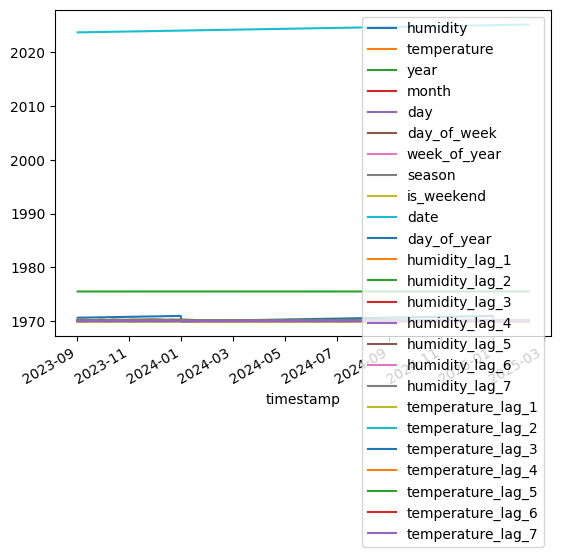

In [23]:
data_filtered.plot()

In [24]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [25]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [26]:
train_data.shape

(500, 25)

In [27]:
test_data.shape

(30, 25)

In [28]:
test_data.head(1)

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,...,humidity_lag_5,humidity_lag_6,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,78.292202,25.997341,2025,1,13,0,3,2,0,2025-01-13,...,71.168637,70.630299,72.844643,25.434972,28.357459,28.945704,28.383165,28.921543,29.145097,28.825509


In [29]:
test_data.tail(1)

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,...,humidity_lag_5,humidity_lag_6,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,68.159624,28.693799,2025,2,11,1,7,0,0,2025-02-11,...,69.511783,71.500943,70.266522,28.251201,28.373742,28.385596,28.271927,28.579177,28.32745,27.775432


In [30]:
test_data.columns

Index(['humidity', 'temperature', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'season', 'is_weekend', 'date', 'day_of_year',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_4',
       'humidity_lag_5', 'humidity_lag_6', 'humidity_lag_7',
       'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3',
       'temperature_lag_4', 'temperature_lag_5', 'temperature_lag_6',
       'temperature_lag_7'],
      dtype='object')

In [31]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='humidity', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,humidity
2,Target type,Regression
3,Original data shape,"(500, 25)"
4,Transformed data shape,"(482, 27)"
5,Transformed train set shape,"(332, 27)"
6,Transformed test set shape,"(150, 27)"
7,Numeric features,23
8,Date features,1
9,Preprocess,True


In [32]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.5909,4.0601,1.9940,0.9042,0.0246,0.0197,0.0233
ridge,Ridge Regression,1.5921,4.0785,1.9991,0.9037,0.0247,0.0197,0.0225
lr,Linear Regression,1.6066,4.1582,2.0187,0.9019,0.0249,0.0199,0.3067
et,Extra Trees Regressor,1.8746,6.3111,2.4814,0.8511,0.0307,0.0233,0.0458
gbr,Gradient Boosting Regressor,1.9343,6.4826,2.5116,0.8475,0.0313,0.0241,0.0458
lightgbm,Light Gradient Boosting Machine,2.0073,6.7346,2.5614,0.8414,0.0317,0.0249,0.0792
rf,Random Forest Regressor,2.0262,7.1424,2.6451,0.8349,0.0328,0.0252,0.0775
ada,AdaBoost Regressor,2.3065,8.4878,2.8985,0.8032,0.0357,0.0284,0.0333
en,Elastic Net,2.4397,9.2747,3.0332,0.7848,0.0372,0.0300,0.0192
lasso,Lasso Regression,2.5568,10.1435,3.1740,0.7647,0.0389,0.0315,0.0192


In [45]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('rf')
model_2 = exp1.create_model('ridge')
model_3 = exp1.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3654,9.9369,3.1523,0.7334,0.0409,0.0311
1,2.0777,8.7716,2.9617,0.8167,0.0365,0.0257
2,2.2024,8.6367,2.9388,0.8524,0.0380,0.0280
3,2.1983,7.6886,2.7728,0.8368,0.0332,0.0267
4,2.3441,9.0248,3.0041,0.7802,0.0379,0.0301
5,2.0550,7.1561,2.6751,0.8288,0.0325,0.0252
6,1.7493,5.7310,2.3939,0.8869,0.0295,0.0215
7,2.0418,6.8687,2.6208,0.7877,0.0315,0.0247
8,1.8188,5.2694,2.2955,0.8720,0.0268,0.0214


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6033,5.1599,2.2715,0.8616,0.0298,0.0209
1,1.6015,4.0938,2.0233,0.9144,0.0246,0.0196
2,1.7521,4.3575,2.0875,0.9255,0.0266,0.0218
3,1.6460,4.4528,2.1102,0.9055,0.0259,0.0202
4,1.9756,5.8152,2.4115,0.8583,0.0295,0.0249
5,1.8298,4.7172,2.1719,0.8871,0.0261,0.0222
6,1.3374,2.7819,1.6679,0.9451,0.0210,0.0167
7,1.8807,5.4816,2.3413,0.8306,0.0282,0.0229
8,1.3366,2.8770,1.6962,0.9301,0.0206,0.0163


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6092,5.1063,2.2597,0.8630,0.0297,0.0210
1,1.6150,4.1437,2.0356,0.9134,0.0247,0.0197
2,1.7543,4.3799,2.0928,0.9252,0.0267,0.0219
3,1.6850,4.5996,2.1447,0.9024,0.0263,0.0206
4,1.9774,5.8057,2.4095,0.8586,0.0296,0.0249
5,1.8129,4.6595,2.1586,0.8885,0.0260,0.0220
6,1.3154,2.6449,1.6263,0.9478,0.0205,0.0164
7,1.8563,5.3682,2.3169,0.8341,0.0279,0.0227
8,1.3333,2.8680,1.6935,0.9303,0.0206,0.0163


In [34]:
# exp1.evaluate_model(model_1)

In [51]:
predictions = exp1.predict_model(model_2, data=test_data)
predict_v = predictions['prediction_label']
real = test_data['humidity']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.2928,8.8157,2.9691,0.7661,0.0381,0.0304


# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

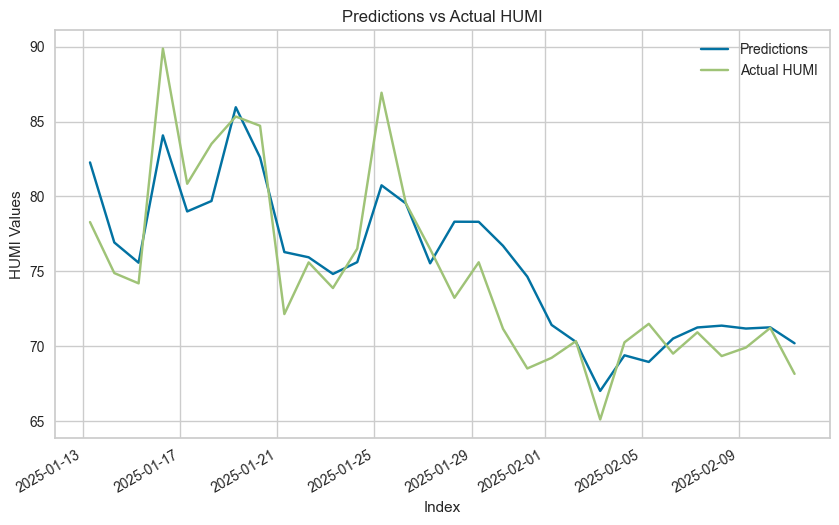

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v, test_data['humidity']], axis=1)
result.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual HUMI')
plt.xlabel('Index')
plt.ylabel('HUMI Values')

# แสดงกราฟ
plt.show()

In [53]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data["humidity"]
y_pred = predict_v

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: 0.7661
Mean Absolute Error (MAE): 2.2928
Root Mean Squared Error (RMSE): 2.9691
Accuracy: 96.94%


In [54]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["humidity"]
y_pred = predict_v

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.7661
Mean Absolute Error (MAE): 2.2928
Root Mean Squared Error (RMSE): 2.9691
Mean Absolute Percentage Error (MAPE): 3.04%
Accuracy: 96.96%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [55]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_2

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    for i in range(1,lag_size+1):
        data_compare[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['humidity'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'humidity'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

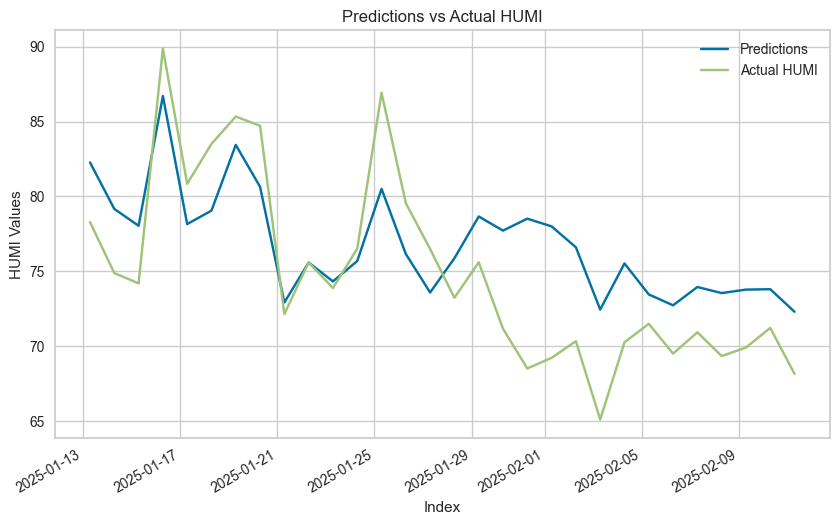

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'], real_data['humidity']], axis=1)
result_plot.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual HUMI')
plt.xlabel('Index')
plt.ylabel('HUMI Values')

# แสดงกราฟ
plt.show()

In [58]:
y_true = test_data["humidity"]
y_pred = result['prediction_label']

In [59]:
# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.4642
Mean Absolute Error (MAE): 3.8687
Root Mean Squared Error (RMSE): 4.4938
Mean Absolute Percentage Error (MAPE): 5.27%
Accuracy: 94.73%


Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.3886,19.2598,4.3886,nan,0.0562,0.0586


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.9560,15.6502,3.9560,nan,0.0513,0.0533


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.1660,10.0238,3.1660,nan,0.0355,0.0352


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.5607,6.5572,2.5607,nan,0.0318,0.0317


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.2775,18.2974,4.2775,nan,0.0519,0.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.7388,3.0236,1.7388,nan,0.0203,0.0204


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.8874,15.1116,3.8874,nan,0.0464,0.0459


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.0627,1.1293,1.0627,nan,0.0144,0.0147


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2223,0.0494,0.2223,nan,0.0029,0.0029


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6599,0.4354,0.6599,nan,0.0088,0.0089


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6524,0.4256,0.6524,nan,0.0085,0.0085


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,6.2590,39.1749,6.2590,nan,0.0738,0.0720


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.1754,10.0830,3.1754,nan,0.0402,0.0399


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6772,7.1672,2.6772,nan,0.0352,0.0350


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.8134,7.9153,2.8134,nan,0.0372,0.0384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.1845,10.1413,3.1845,nan,0.0407,0.0421


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,6.7040,44.9434,6.7040,nan,0.0888,0.0942


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,10.1272,102.5599,10.1272,nan,0.1360,0.1478


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,8.9494,80.0921,8.9494,nan,0.1199,0.1293


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,6.4893,42.1105,6.4893,nan,0.0871,0.0923


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,7.6168,58.0155,7.6168,nan,0.1090,0.1170


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.5092,30.3514,5.5092,nan,0.0745,0.0784


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.2316,4.9800,2.2316,nan,0.0303,0.0312


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.4933,12.2034,3.4933,nan,0.0484,0.0503


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.2614,10.6367,3.2614,nan,0.0443,0.0460


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.4667,19.9515,4.4667,nan,0.0616,0.0644


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.1358,17.1045,4.1358,nan,0.0567,0.0592


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.8462,8.1007,2.8462,nan,0.0386,0.0400


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.4139,19.4826,4.4139,nan,0.0619,0.0648


Processing model: Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.9821,15.8569,3.9821,nan,0.0490,0.0509


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.2830,18.3441,4.2830,nan,0.0549,0.0572


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.8446,14.7811,3.8446,nan,0.0499,0.0518


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.1689,10.0417,3.1689,nan,0.0355,0.0353


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.6923,7.2484,2.6923,nan,0.0334,0.0333


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.4539,19.8371,4.4539,nan,0.0541,0.0533


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.8932,3.5843,1.8932,nan,0.0222,0.0222


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.0752,16.6071,4.0752,nan,0.0487,0.0481


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.7775,0.6045,0.7775,nan,0.0106,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0078,0.0001,0.0078,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.4438,0.1970,0.4438,nan,0.0059,0.0060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.8263,0.6828,0.8263,nan,0.0107,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.4178,41.1880,6.4178,nan,0.0758,0.0738


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.3908,11.4974,3.3908,nan,0.0430,0.0426


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.8979,8.3981,2.8979,nan,0.0381,0.0379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.6408,6.9738,2.6408,nan,0.0350,0.0361


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.0574,9.3479,3.0574,nan,0.0391,0.0404


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.5562,42.9839,6.5562,nan,0.0870,0.0921


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,9.9989,99.9776,9.9989,nan,0.1344,0.1459


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,8.7729,76.9645,8.7729,nan,0.1177,0.1267


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.2667,39.2712,6.2667,nan,0.0842,0.0891


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,7.3378,53.8433,7.3378,nan,0.1052,0.1127


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,5.2642,27.7121,5.2642,nan,0.0713,0.0749


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.9613,3.8469,1.9613,nan,0.0267,0.0274


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.2241,10.3950,3.2241,nan,0.0447,0.0464


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.0240,9.1445,3.0240,nan,0.0412,0.0426


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.2042,17.6752,4.2042,nan,0.0580,0.0606


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.8683,14.9634,3.8683,nan,0.0531,0.0553


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.5841,6.6776,2.5841,nan,0.0352,0.0363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.1446,17.1781,4.1446,nan,0.0582,0.0608


Processing model: LinearRegression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.9968,15.9748,3.9968,nan,0.0492,0.0511


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.2902,18.4058,4.2902,nan,0.0550,0.0573


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.8602,14.9012,3.8602,nan,0.0501,0.0520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.0982,9.5989,3.0982,nan,0.0347,0.0345


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.6549,7.0485,2.6549,nan,0.0330,0.0328


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.4250,19.5803,4.4250,nan,0.0538,0.0530


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.8467,3.4102,1.8467,nan,0.0216,0.0216


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.0345,16.2774,4.0345,nan,0.0482,0.0476


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.7851,0.6164,0.7851,nan,0.0107,0.0109


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0224,0.0005,0.0224,nan,0.0003,0.0003


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.4834,0.2337,0.4834,nan,0.0064,0.0065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.7702,0.5932,0.7702,nan,0.0100,0.0101


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.3557,40.3951,6.3557,nan,0.0750,0.0731


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.3489,11.2154,3.3489,nan,0.0425,0.0421


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.8623,8.1926,2.8623,nan,0.0376,0.0374


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.6916,7.2447,2.6916,nan,0.0356,0.0368


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.1259,9.7714,3.1259,nan,0.0400,0.0413


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.6163,43.7754,6.6163,nan,0.0877,0.0930


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,10.0640,101.2842,10.0640,nan,0.1352,0.1469


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,8.8061,77.5467,8.8061,nan,0.1181,0.1272


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.2738,39.3607,6.2738,nan,0.0843,0.0892


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7.3154,53.5154,7.3154,nan,0.1049,0.1123


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.2482,27.5439,5.2482,nan,0.0711,0.0747


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.9314,3.7303,1.9314,nan,0.0263,0.0270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.1888,10.1687,3.1888,nan,0.0442,0.0459


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.9961,8.9765,2.9961,nan,0.0408,0.0422


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.1638,17.3374,4.1638,nan,0.0575,0.0600


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.8229,14.6148,3.8229,nan,0.0525,0.0547


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.5358,6.4301,2.5358,nan,0.0345,0.0356


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.0908,16.7346,4.0908,nan,0.0575,0.0600


Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.1780,103.5912,10.1780,nan,0.1208,0.1300


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,12.4258,154.3994,12.4258,nan,0.1516,0.1659


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,12.3538,152.6163,12.3538,nan,0.1521,0.1665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.3522,1.8285,1.3522,nan,0.0148,0.0150


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.1516,26.5387,5.1516,nan,0.0610,0.0637


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.8395,8.0627,2.8395,nan,0.0330,0.0340


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.4514,19.8151,4.4514,nan,0.0503,0.0522


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.3724,11.3733,3.3724,nan,0.0386,0.0398


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.6648,113.7375,10.6648,nan,0.1361,0.1478


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.5884,57.5839,7.5884,nan,0.0945,0.1004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,8.8955,79.1303,8.8955,nan,0.1122,0.1204


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.9571,48.4019,6.9571,nan,0.0859,0.0909


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.5895,2.5265,1.5895,nan,0.0179,0.0183


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.0728,25.7336,5.0728,nan,0.0611,0.0638


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.5782,31.1165,5.5782,nan,0.0695,0.0729


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.0951,101.9112,10.0951,nan,0.1275,0.1378


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.9567,99.1355,9.9567,nan,0.1222,0.1317


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,12.7901,163.5858,12.7901,nan,0.1632,0.1797


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,15.9641,254.8513,15.9641,nan,0.2067,0.2330


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,14.9514,223.5433,14.9514,nan,0.1930,0.2160


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,12.8740,165.7390,12.8740,nan,0.1659,0.1830


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,16.1587,261.1037,16.1587,nan,0.2187,0.2482


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,12.7608,162.8373,12.7608,nan,0.1647,0.1816


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.7471,95.0057,9.7471,nan,0.1261,0.1363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,12.1538,147.7158,12.1538,nan,0.1590,0.1748


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.3491,107.1042,10.3491,nan,0.1344,0.1459


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,11.0241,121.5304,11.0241,nan,0.1456,0.1590


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.7337,94.7450,9.7337,nan,0.1286,0.1392


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,8.7025,75.7341,8.7025,nan,0.1138,0.1222


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.9398,119.6800,10.9398,nan,0.1469,0.1605


Processing model: GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,6.1393,37.6909,6.1393,nan,0.0746,0.0784


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.9905,80.8290,8.9905,nan,0.1120,0.1201


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.8393,96.8111,9.8393,nan,0.1230,0.1326


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2299,0.0529,0.2299,nan,0.0025,0.0026


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.2984,18.4763,4.2984,nan,0.0512,0.0532


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.9614,8.7701,2.9614,nan,0.0344,0.0355


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,5.1036,26.0463,5.1036,nan,0.0574,0.0598


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.5784,20.9614,4.5784,nan,0.0520,0.0540


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,11.1698,124.7643,11.1698,nan,0.1421,0.1548


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.1451,83.6329,9.1451,nan,0.1128,0.1210


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.2433,67.9523,8.2433,nan,0.1044,0.1116


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,7.4049,54.8326,7.4049,nan,0.0912,0.0968


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.6288,2.6529,1.6288,nan,0.0184,0.0187


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.9589,15.6729,3.9589,nan,0.0480,0.0498


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.3156,18.6247,4.3156,nan,0.0542,0.0564


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.0364,100.7289,10.0364,nan,0.1268,0.1370


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.1701,103.4314,10.1701,nan,0.1247,0.1345


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,13.2879,176.5695,13.2879,nan,0.1690,0.1867


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,16.6816,278.2771,16.6816,nan,0.2151,0.2435


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15.2805,233.4925,15.2805,nan,0.1969,0.2207


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,12.7704,163.0832,12.7704,nan,0.1647,0.1815


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,16.1844,261.9346,16.1844,nan,0.2190,0.2486


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,13.6030,185.0416,13.6030,nan,0.1747,0.1936


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.8785,118.3425,10.8785,nan,0.1398,0.1521


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.8603,117.9469,10.8603,nan,0.1433,0.1562


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.7948,95.9376,9.7948,nan,0.1277,0.1381


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,11.7104,137.1344,11.7104,nan,0.1540,0.1689


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,11.2385,126.3048,11.2385,nan,0.1471,0.1607


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.0843,101.6923,10.0843,nan,0.1307,0.1416


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,11.9585,143.0048,11.9585,nan,0.1595,0.1754


Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.0356,81.6422,9.0356,nan,0.1079,0.1154


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.2337,104.7289,10.2337,nan,0.1265,0.1367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,11.5998,134.5560,11.5998,nan,0.1435,0.1563


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7520,0.5655,0.7520,nan,0.0082,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,5.4661,29.8777,5.4661,nan,0.0646,0.0676


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.2462,10.5380,3.2462,nan,0.0377,0.0389


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,5.8051,33.6996,5.8051,nan,0.0651,0.0680


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,4.2416,17.9909,4.2416,nan,0.0483,0.0501


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.4182,108.5380,10.4182,nan,0.1331,0.1444


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.3133,86.7383,9.3133,nan,0.1147,0.1232


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.0489,81.8833,9.0489,nan,0.1141,0.1225


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,6.8550,46.9906,6.8550,nan,0.0847,0.0896


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7048,0.4968,0.7048,nan,0.0080,0.0081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.7939,14.3940,3.7939,nan,0.0460,0.0477


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,5.7393,32.9398,5.7393,nan,0.0715,0.0750


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.3571,107.2685,10.3571,nan,0.1306,0.1414


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.8644,97.3056,9.8644,nan,0.1211,0.1305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.3265,151.9423,12.3265,nan,0.1577,0.1732


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.8968,252.7081,15.8968,nan,0.2059,0.2320


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,14.5673,212.2066,14.5673,nan,0.1885,0.2104


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,13.1922,174.0331,13.1922,nan,0.1697,0.1875


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.0986,292.3608,17.0986,nan,0.2300,0.2626


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,14.0195,196.5453,14.0195,nan,0.1796,0.1995


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.7284,115.0976,10.7284,nan,0.1380,0.1500


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,11.8683,140.8567,11.8683,nan,0.1556,0.1707


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,11.8030,139.3115,11.8030,nan,0.1519,0.1664


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.7031,161.3688,12.7031,nan,0.1660,0.1832


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,11.8416,140.2230,11.8416,nan,0.1544,0.1694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.8860,118.5054,10.8860,nan,0.1404,0.1528


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.4419,154.8000,12.4419,nan,0.1654,0.1825


Processing model: RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.5119,90.4758,9.5119,nan,0.1133,0.1215


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12.6493,160.0038,12.6493,nan,0.1542,0.1689


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12.0967,146.3308,12.0967,nan,0.1492,0.1630


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4274,0.1827,0.4274,nan,0.0047,0.0048


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.4062,29.2275,5.4062,nan,0.0640,0.0669


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.7593,14.1325,3.7593,nan,0.0435,0.0450


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.0120,25.1199,5.0120,nan,0.0564,0.0587


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.4260,19.5893,4.4260,nan,0.0503,0.0522


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.6738,113.9304,10.6738,nan,0.1362,0.1479


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8.5038,72.3153,8.5038,nan,0.1053,0.1125


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.0120,81.2169,9.0120,nan,0.1136,0.1220


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.1379,50.9495,7.1379,nan,0.0881,0.0933


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.1185,4.4879,2.1185,nan,0.0238,0.0244


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.5812,20.9871,4.5812,nan,0.0553,0.0576


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.1312,17.0670,4.1312,nan,0.0519,0.0540


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.2381,104.8189,10.2381,nan,0.1292,0.1398


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.8824,97.6623,9.8824,nan,0.1213,0.1307


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,11.7796,138.7588,11.7796,nan,0.1512,0.1655


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,16.6874,278.4681,16.6874,nan,0.2151,0.2435


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15.3740,236.3602,15.3740,nan,0.1980,0.2221


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12.8652,165.5139,12.8652,nan,0.1658,0.1829


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15.7082,246.7480,15.7082,nan,0.2132,0.2412


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,13.2512,175.5936,13.2512,nan,0.1705,0.1886


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.8660,97.3377,9.8660,nan,0.1276,0.1380


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,11.8202,139.7170,11.8202,nan,0.1550,0.1700


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.3087,106.2692,10.3087,nan,0.1339,0.1453


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,11.2171,125.8233,11.2171,nan,0.1479,0.1617


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.3422,106.9617,10.3422,nan,0.1361,0.1479


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8.5968,73.9045,8.5968,nan,0.1125,0.1207


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.8908,118.6087,10.8908,nan,0.1462,0.1598


Processing model: AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.2868,86.2446,9.2868,nan,0.1108,0.1186


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,12.6918,161.0817,12.6918,nan,0.1546,0.1695


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,13.7332,188.6014,13.7332,nan,0.1677,0.1851


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3269,0.1068,0.3269,nan,0.0036,0.0036


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.9281,47.9990,6.9281,nan,0.0813,0.0857


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,4.9937,24.9371,4.9937,nan,0.0574,0.0598


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,4.8857,23.8697,4.8857,nan,0.0550,0.0573


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,4.8269,23.2992,4.8269,nan,0.0548,0.0570


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,10.6882,114.2385,10.6882,nan,0.1364,0.1481


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,11.2868,127.3912,11.2868,nan,0.1375,0.1493


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.6204,74.3107,8.6204,nan,0.1090,0.1167


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,5.9918,35.9017,5.9918,nan,0.0745,0.0783


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.5790,2.4933,1.5790,nan,0.0178,0.0182


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,3.9972,15.9776,3.9972,nan,0.0484,0.0502


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,5.2487,27.5492,5.2487,nan,0.0655,0.0686


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.5008,72.2636,8.5008,nan,0.1084,0.1161


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.3726,87.8450,9.3726,nan,0.1154,0.1240


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,11.6715,136.2250,11.6715,nan,0.1499,0.1640


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.6876,246.0995,15.6876,nan,0.2035,0.2289


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,16.2825,265.1182,16.2825,nan,0.2085,0.2352


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,14.5054,210.4074,14.5054,nan,0.1851,0.2062


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,16.8838,285.0612,16.8838,nan,0.2274,0.2593


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.2470,232.4698,15.2470,nan,0.1939,0.2170


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,10.2379,104.8137,10.2379,nan,0.1321,0.1432


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,12.2270,149.5001,12.2270,nan,0.1599,0.1759


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,10.8049,116.7448,10.8049,nan,0.1399,0.1523


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,12.0573,145.3784,12.0573,nan,0.1582,0.1739


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,11.8224,139.7697,11.8224,nan,0.1542,0.1691


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.5322,90.8628,9.5322,nan,0.1240,0.1338


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,11.6957,136.7901,11.6957,nan,0.1562,0.1716


Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.8390,34.0933,5.8390,nan,0.0711,0.0746


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,8.6683,75.1388,8.6683,nan,0.1082,0.1158


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.3660,87.7214,9.3660,nan,0.1174,0.1262


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.9276,3.7157,1.9276,nan,0.0214,0.0214


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.3212,18.6724,4.3212,nan,0.0514,0.0534


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.7681,7.6623,2.7681,nan,0.0322,0.0331


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.4269,11.7435,3.4269,nan,0.0389,0.0402


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.3257,11.0606,3.3257,nan,0.0381,0.0393


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,12.5313,157.0329,12.5313,nan,0.1581,0.1737


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.8083,96.2019,9.8083,nan,0.1205,0.1297


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,10.3525,107.1744,10.3525,nan,0.1295,0.1401


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,8.0055,64.0883,8.0055,nan,0.0983,0.1046


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.2705,0.0732,0.2705,nan,0.0031,0.0031


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.7417,32.9666,5.7417,nan,0.0689,0.0722


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,7.2366,52.3685,7.2366,nan,0.0893,0.0946


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,11.1023,123.2621,11.1023,nan,0.1394,0.1516


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.7797,95.6417,9.7797,nan,0.1201,0.1293


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,14.0045,196.1251,14.0045,nan,0.1774,0.1968


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,17.0805,291.7424,17.0805,nan,0.2197,0.2493


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,16.5467,273.7927,16.5467,nan,0.2116,0.2390


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,14.8086,219.2951,14.8086,nan,0.1886,0.2105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,18.2232,332.0848,18.2232,nan,0.2434,0.2799


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,14.2655,203.5041,14.2655,nan,0.1825,0.2030


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,12.0519,145.2475,12.0519,nan,0.1538,0.1686


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,13.4308,180.3863,13.4308,nan,0.1744,0.1932


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,12.3371,152.2031,12.3371,nan,0.1583,0.1739


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,13.5930,184.7684,13.5930,nan,0.1767,0.1960


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,12.9211,166.9555,12.9211,nan,0.1674,0.1848


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,11.7831,138.8418,11.7831,nan,0.1511,0.1654


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,13.9757,195.3199,13.9757,nan,0.1841,0.2050


Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,7.7875,60.6452,7.7875,nan,0.0937,0.0995


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.8622,117.9873,10.8622,nan,0.1338,0.1450


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.5935,134.4089,11.5935,nan,0.1434,0.1562


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.6846,0.4687,0.6846,nan,0.0075,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,7.0759,50.0677,7.0759,nan,0.0829,0.0875


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.9616,24.6179,4.9616,nan,0.0571,0.0594


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.9137,34.9717,5.9137,nan,0.0663,0.0693


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.8816,34.5928,5.8816,nan,0.0664,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,14.4618,209.1447,14.4618,nan,0.1804,0.2004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.3334,128.4469,11.3334,nan,0.1380,0.1499


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.8417,140.2265,11.8417,nan,0.1468,0.1603


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,9.1500,83.7220,9.1500,nan,0.1116,0.1196


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.4734,2.1709,1.4734,nan,0.0166,0.0169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,6.9728,48.6202,6.9728,nan,0.0830,0.0877


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,8.0512,64.8221,8.0512,nan,0.0988,0.1053


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,11.8754,141.0249,11.8754,nan,0.1484,0.1621


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.7448,115.4512,10.7448,nan,0.1313,0.1421


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,14.9451,223.3549,14.9451,nan,0.1882,0.2100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,17.9465,322.0758,17.9465,nan,0.2296,0.2619


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,17.6606,311.8973,17.6606,nan,0.2243,0.2551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,15.9495,254.3858,15.9495,nan,0.2018,0.2267


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,19.1349,366.1436,19.1349,nan,0.2542,0.2939


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,15.0884,227.6604,15.0884,nan,0.1920,0.2147


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,12.9186,166.8908,12.9186,nan,0.1640,0.1807


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,14.0410,197.1496,14.0410,nan,0.1816,0.2020


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,12.8935,166.2419,12.8935,nan,0.1649,0.1818


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,14.1777,201.0080,14.1777,nan,0.1836,0.2044


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,13.4438,180.7346,13.4438,nan,0.1736,0.1923


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,12.2928,151.1121,12.2928,nan,0.1572,0.1726


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,14.4471,208.7191,14.4471,nan,0.1897,0.2120


Processing model: LassoLars


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,7.7874,60.6429,7.7874,nan,0.0937,0.0995


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.8605,117.9499,10.8605,nan,0.1338,0.1450


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.5919,134.3726,11.5919,nan,0.1434,0.1562


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.6842,0.4681,0.6842,nan,0.0075,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,7.0761,50.0710,7.0761,nan,0.0829,0.0875


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.9612,24.6131,4.9612,nan,0.0570,0.0594


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.9136,34.9703,5.9136,nan,0.0662,0.0693


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.8819,34.5967,5.8819,nan,0.0664,0.0694


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.4619,209.1465,14.4619,nan,0.1804,0.2004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.3335,128.4482,11.3335,nan,0.1380,0.1499


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.8427,140.2490,11.8427,nan,0.1468,0.1603


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,9.1510,83.7399,9.1510,nan,0.1116,0.1196


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.4741,2.1731,1.4741,nan,0.0166,0.0170


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,6.9736,48.6305,6.9736,nan,0.0830,0.0877


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,8.0515,64.8272,8.0515,nan,0.0989,0.1053


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,11.8759,141.0360,11.8759,nan,0.1484,0.1622


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.7458,115.4718,10.7458,nan,0.1313,0.1421


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.9459,223.3804,14.9459,nan,0.1882,0.2100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,17.9469,322.0903,17.9469,nan,0.2296,0.2619


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,17.6610,311.9121,17.6610,nan,0.2243,0.2551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,15.9500,254.4025,15.9500,nan,0.2018,0.2268


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,19.1354,366.1631,19.1354,nan,0.2542,0.2939


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,15.0890,227.6768,15.0890,nan,0.1920,0.2147


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,12.9195,166.9140,12.9195,nan,0.1640,0.1807


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.0417,197.1694,14.0417,nan,0.1816,0.2020


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,12.8941,166.2576,12.8941,nan,0.1649,0.1818


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.1785,201.0294,14.1785,nan,0.1836,0.2045


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,13.4444,180.7532,13.4444,nan,0.1736,0.1923


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,12.2934,151.1266,12.2934,nan,0.1572,0.1726


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.4477,208.7369,14.4477,nan,0.1897,0.2120


Processing model: HuberRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,4.1923,17.5751,4.1923,nan,0.0515,0.0535


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,7.1933,51.7438,7.1933,nan,0.0906,0.0961


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.7560,33.1317,5.7560,nan,0.0738,0.0776


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,9.0229,81.4135,9.0229,nan,0.1046,0.1004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.3955,0.1564,0.3955,nan,0.0048,0.0049


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.1443,1.3094,1.1443,nan,0.0136,0.0137


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.8310,8.0144,2.8310,nan,0.0333,0.0332


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.0680,4.2765,2.0680,nan,0.0244,0.0244


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.8858,78.9575,8.8858,nan,0.1146,0.1232


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.1050,26.0612,5.1050,nan,0.0645,0.0675


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.8605,34.3453,5.8605,nan,0.0753,0.0793


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.4856,12.1497,3.4856,nan,0.0440,0.0456


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,6.1724,38.0985,6.1724,nan,0.0728,0.0710


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.9669,0.9350,0.9669,nan,0.0119,0.0122


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.0256,9.1540,3.0256,nan,0.0383,0.0396


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.8879,34.6678,5.8879,nan,0.0763,0.0804


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.4592,11.9662,3.4592,nan,0.0442,0.0458


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,7.9637,63.4210,7.9637,nan,0.1047,0.1119


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.7734,116.0666,10.7734,nan,0.1441,0.1572


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,11.0694,122.5321,11.0694,nan,0.1464,0.1599


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.1969,103.9775,10.1969,nan,0.1336,0.1450


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,15.0182,225.5467,15.0182,nan,0.2047,0.2306


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.0320,100.6414,10.0320,nan,0.1317,0.1428


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.5806,73.6273,8.5806,nan,0.1119,0.1200


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.4532,109.2697,10.4532,nan,0.1382,0.1504


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,9.1726,84.1374,9.1726,nan,0.1200,0.1293


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.7498,115.5580,10.7498,nan,0.1422,0.1550


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.1433,102.8859,10.1433,nan,0.1337,0.1451


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.8468,78.2656,8.8468,nan,0.1155,0.1242


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,11.5387,133.1411,11.5387,nan,0.1543,0.1693


Processing model: DecisionTreeRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,9.7361,94.7922,9.7361,nan,0.1158,0.1244


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,11.7576,138.2402,11.7576,nan,0.1440,0.1570


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,12.4434,154.8374,12.4434,nan,0.1531,0.1677


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.6323,2.6644,1.6323,nan,0.0178,0.0182


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,5.7958,33.5916,5.7958,nan,0.0684,0.0717


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.2529,52.6051,7.2529,nan,0.0823,0.0868


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,6.2010,38.4525,6.2010,nan,0.0694,0.0727


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.0579,9.3509,3.0579,nan,0.0351,0.0361


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,10.6107,112.5868,10.6107,nan,0.1355,0.1471


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.5882,57.5814,7.5882,nan,0.0945,0.1004


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.6274,2.6483,1.6274,nan,0.0215,0.0220


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.2300,52.2728,7.2300,nan,0.0892,0.0945


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.8502,0.7228,0.8502,nan,0.0096,0.0098


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.8757,8.2697,2.8757,nan,0.0351,0.0361


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.3029,5.3032,2.3029,nan,0.0293,0.0301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.7674,60.3321,7.7674,nan,0.0995,0.1061


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,10.4417,109.0301,10.4417,nan,0.1278,0.1381


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,13.9103,193.4958,13.9103,nan,0.1763,0.1955


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,17.5295,307.2827,17.5295,nan,0.2249,0.2558


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,16.7179,279.4896,16.7179,nan,0.2135,0.2415


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,13.8729,192.4578,13.8729,nan,0.1777,0.1972


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,17.6474,311.4313,17.6474,nan,0.2366,0.2710


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,16.3909,268.6626,16.3909,nan,0.2070,0.2333


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,11.2607,126.8040,11.2607,nan,0.1444,0.1575


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,13.2499,175.5597,13.2499,nan,0.1722,0.1906


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,12.5049,156.3721,12.5049,nan,0.1603,0.1763


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,9.9999,99.9973,9.9999,nan,0.1329,0.1442


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,8.8765,78.7931,8.8765,nan,0.1179,0.1270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,10.9324,119.5173,10.9324,nan,0.1409,0.1535


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,10.6333,113.0672,10.6333,nan,0.1430,0.1560


Processing model: OrthogonalMatchingPursuit


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.7940,22.9825,4.7940,nan,0.0587,0.0612


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.6038,43.6103,6.6038,nan,0.0834,0.0882


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.1825,38.2229,6.1825,nan,0.0790,0.0833


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,10.2557,105.1786,10.2557,nan,0.1197,0.1141


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.7589,3.0939,1.7589,nan,0.0217,0.0218


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.7839,22.8858,4.7839,nan,0.0583,0.0573


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.8542,46.9797,6.8542,nan,0.0827,0.0803


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.3992,40.9501,6.3992,nan,0.0776,0.0755


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.0627,36.7569,6.0627,nan,0.0796,0.0840


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.5470,6.4870,2.5470,nan,0.0327,0.0337


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.2188,17.7983,4.2188,nan,0.0548,0.0571


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.5704,2.4662,1.5704,nan,0.0201,0.0205


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,8.8459,78.2502,8.8459,nan,0.1060,0.1018


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.4680,2.1549,1.4680,nan,0.0184,0.0185


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.6044,2.5741,1.6044,nan,0.0205,0.0210


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.8709,23.7259,4.8709,nan,0.0635,0.0665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.5185,6.3429,2.5185,nan,0.0323,0.0333


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.9789,48.7047,6.9789,nan,0.0923,0.0981


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,9.6477,93.0780,9.6477,nan,0.1300,0.1408


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,8.9596,80.2753,8.9596,nan,0.1201,0.1294


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.8724,61.9753,7.8724,nan,0.1047,0.1119


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,13.1237,172.2327,13.1237,nan,0.1811,0.2015


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.9958,63.9326,7.9958,nan,0.1063,0.1138


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.7859,46.0489,6.7859,nan,0.0895,0.0949


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,8.7999,77.4374,8.7999,nan,0.1176,0.1266


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.4026,54.7979,7.4026,nan,0.0980,0.1044


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,9.0129,81.2329,9.0129,nan,0.1206,0.1300


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,8.4701,71.7431,8.4701,nan,0.1128,0.1211


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.1853,51.6279,7.1853,nan,0.0948,0.1009


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,10.2771,105.6183,10.2771,nan,0.1385,0.1508


Processing model: KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,6.2920,39.5897,6.2920,nan,0.0764,0.0804


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.6970,94.0324,9.6970,nan,0.1203,0.1295


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.7287,115.1043,10.7287,nan,0.1334,0.1446


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.2170,17.7834,4.2170,nan,0.0475,0.0469


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,5.3869,29.0192,5.3869,nan,0.0637,0.0666


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.4174,2.0090,1.4174,nan,0.0166,0.0170


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6986,0.4881,0.6986,nan,0.0081,0.0082


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.2104,0.0443,0.2104,nan,0.0025,0.0025


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.7791,163.3052,12.7791,nan,0.1610,0.1771


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.7068,94.2214,9.7068,nan,0.1193,0.1284


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,13.3942,179.4049,13.3942,nan,0.1645,0.1813


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11.7351,137.7136,11.7351,nan,0.1410,0.1534


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.1452,1.3116,1.1452,nan,0.0129,0.0132


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.5200,72.5903,8.5200,nan,0.1005,0.1071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11.5825,134.1553,11.5825,nan,0.1393,0.1514


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,13.3057,177.0411,13.3057,nan,0.1649,0.1817


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.9356,119.5872,10.9356,nan,0.1334,0.1446


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,15.3760,236.4220,15.3760,nan,0.1931,0.2161


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,18.0233,324.8402,18.0233,nan,0.2305,0.2630


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,13.7799,189.8860,13.7799,nan,0.1792,0.1990


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.6693,160.5115,12.6693,nan,0.1635,0.1801


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,17.8967,320.2918,17.8967,nan,0.2396,0.2749


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.7444,162.4205,12.7444,nan,0.1645,0.1814


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11.5100,132.4803,11.5100,nan,0.1473,0.1610


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,13.2143,174.6170,13.2143,nan,0.1718,0.1901


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.9018,118.8500,10.9018,nan,0.1411,0.1537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.4872,155.9311,12.4872,nan,0.1634,0.1801


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11.9194,142.0722,11.9194,nan,0.1554,0.1705


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.3986,88.3338,9.3986,nan,0.1223,0.1320


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.4559,155.1487,12.4559,nan,0.1656,0.1827


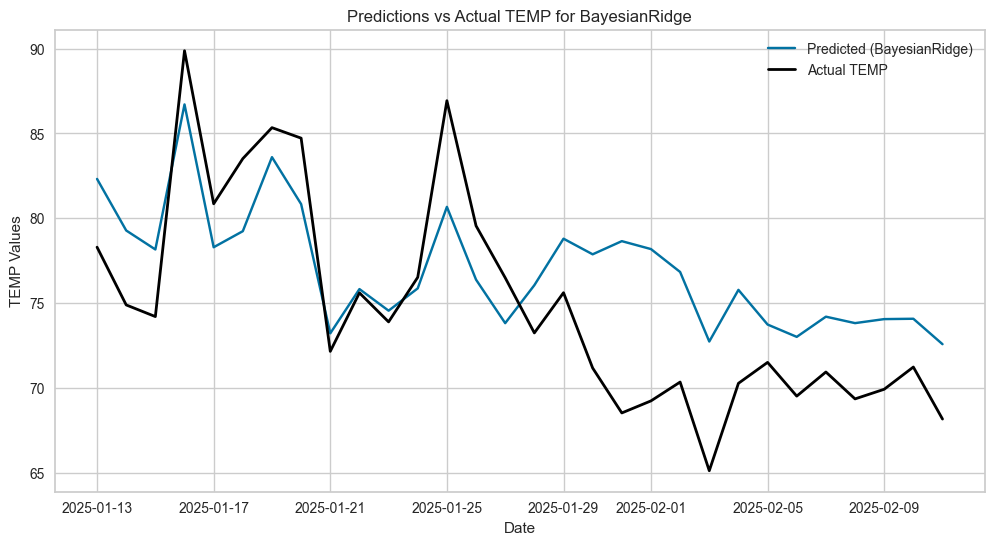

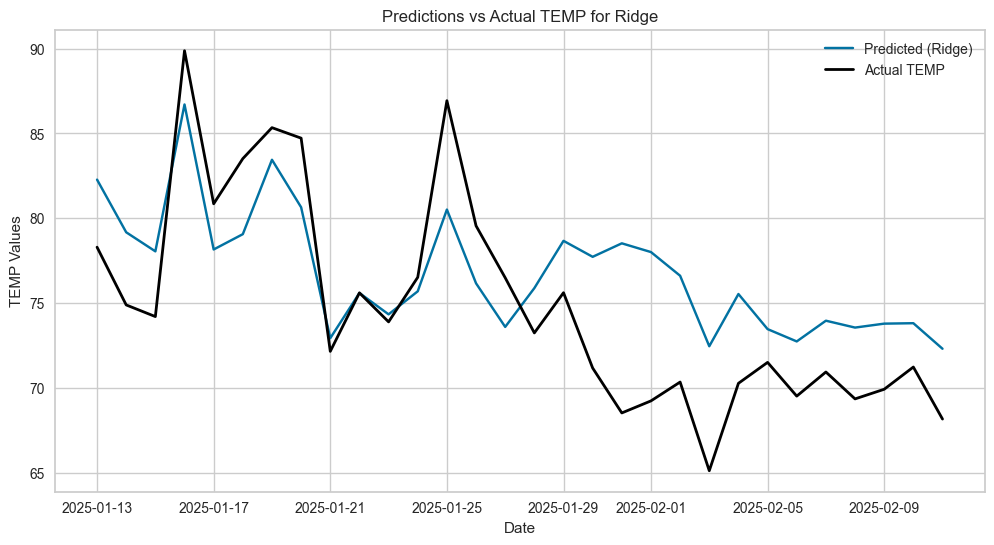

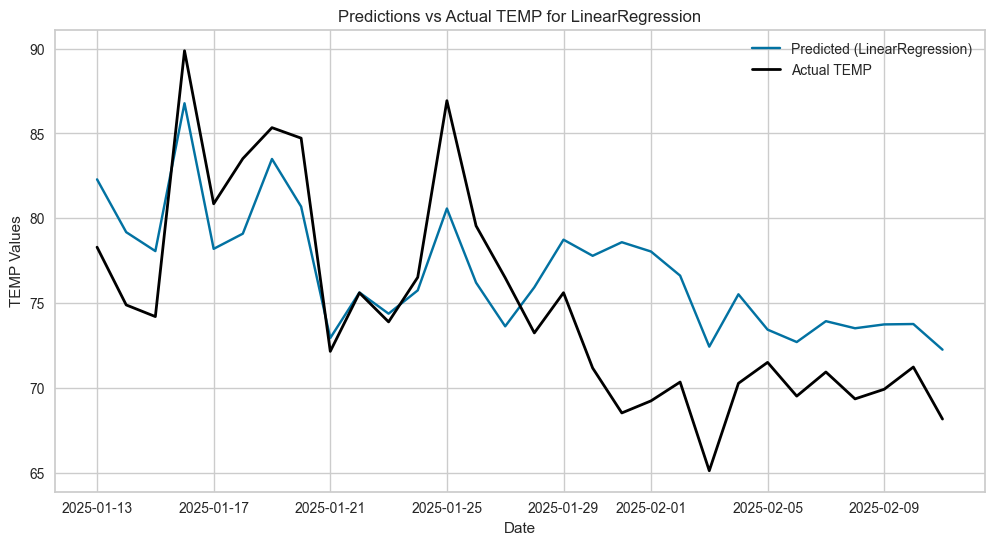

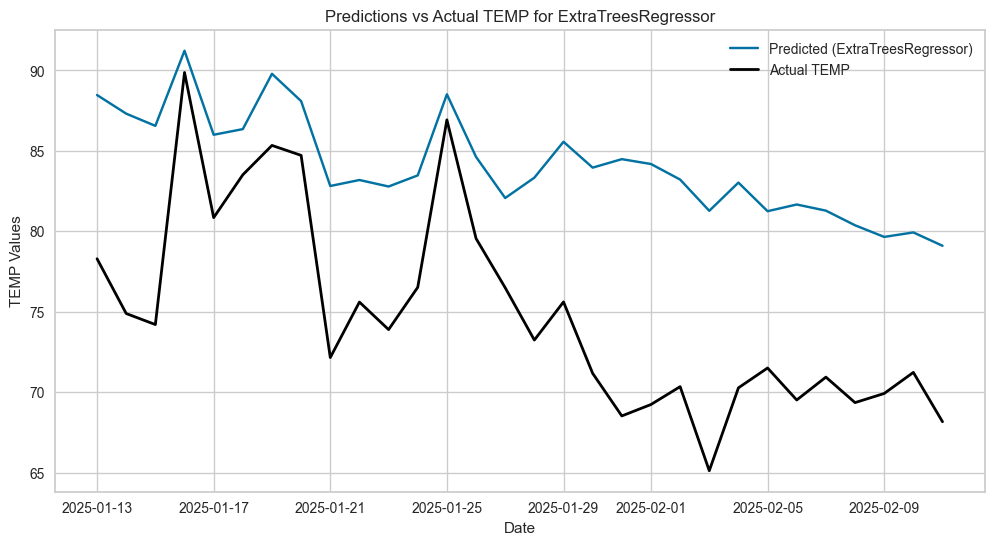

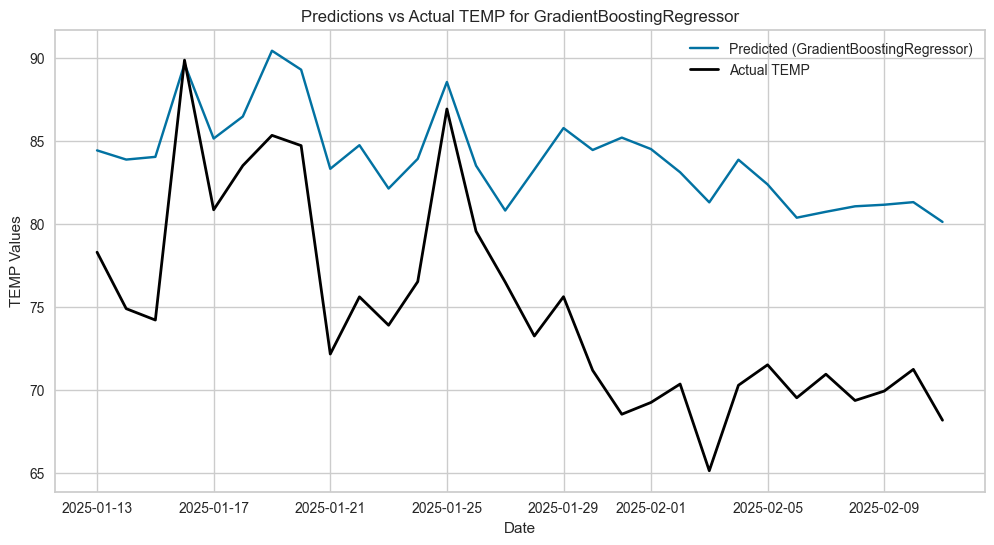

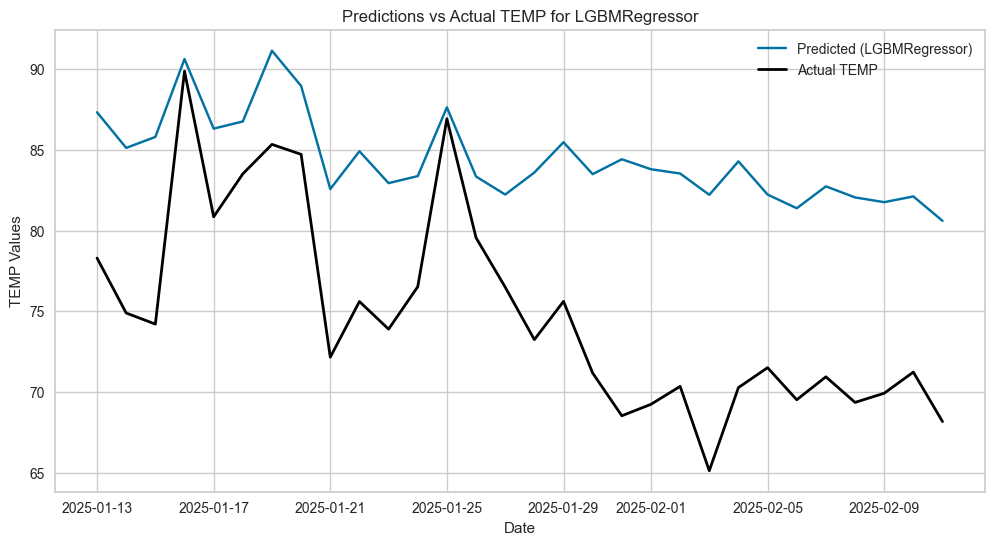

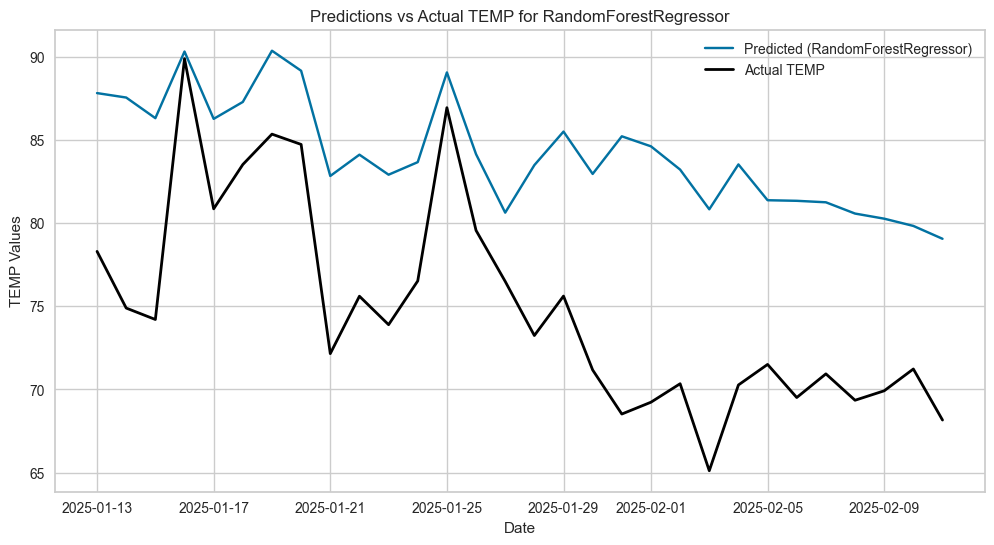

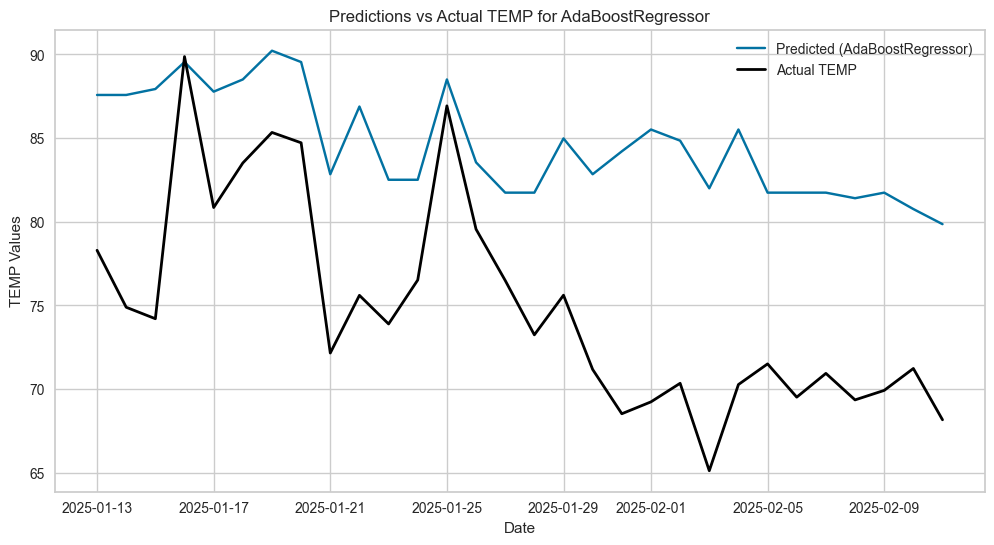

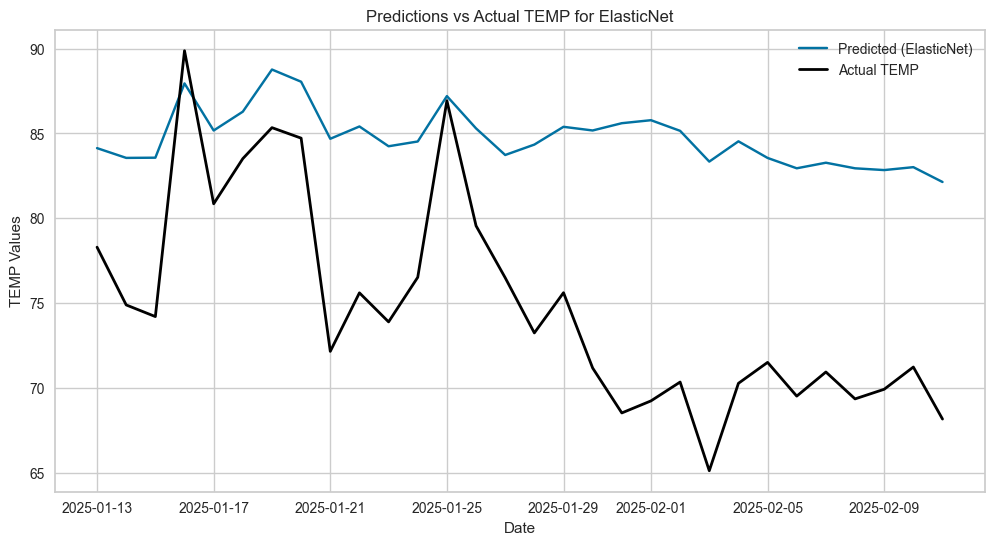

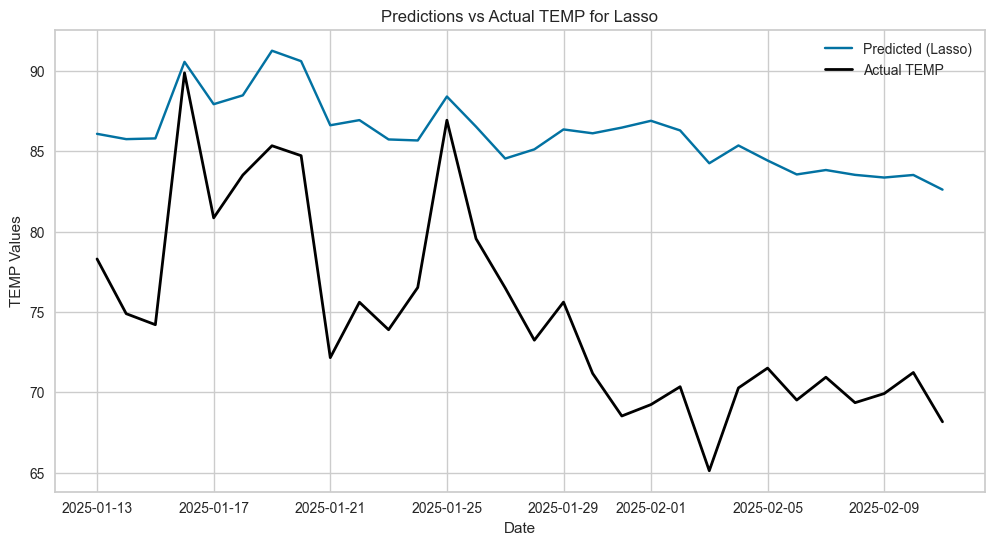

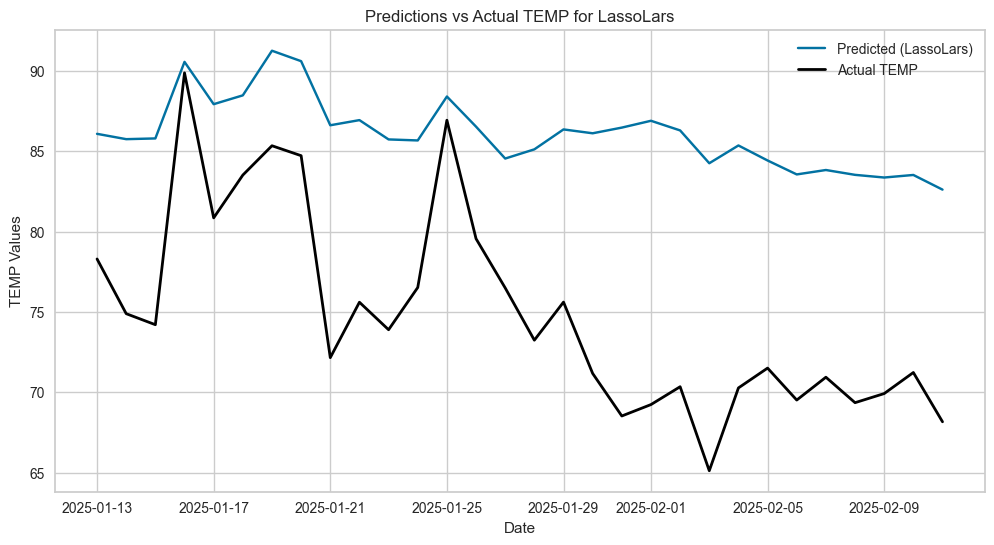

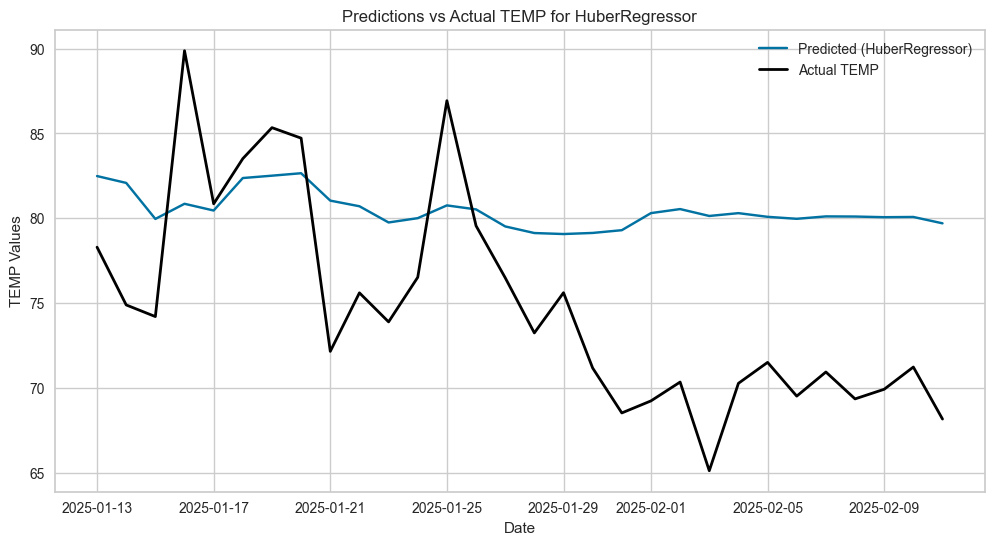

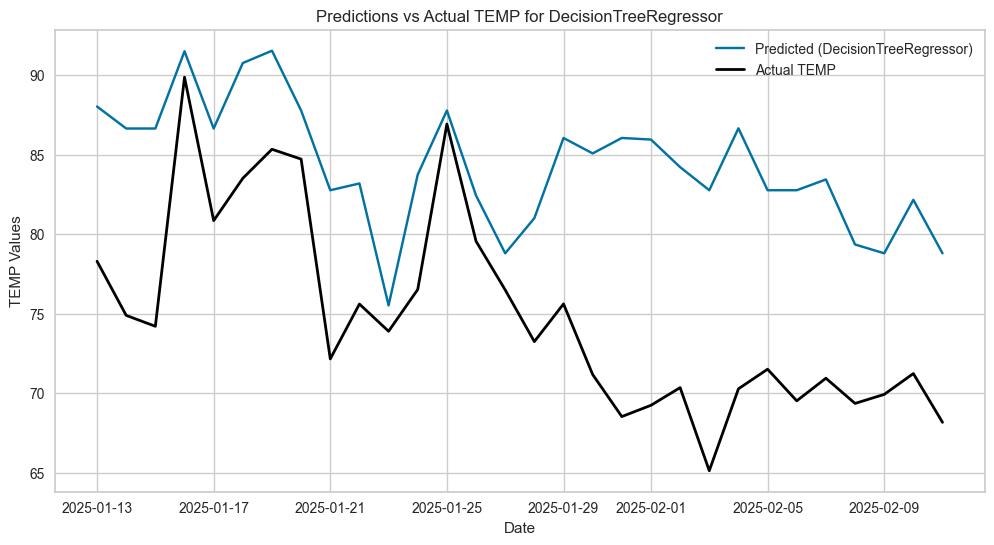

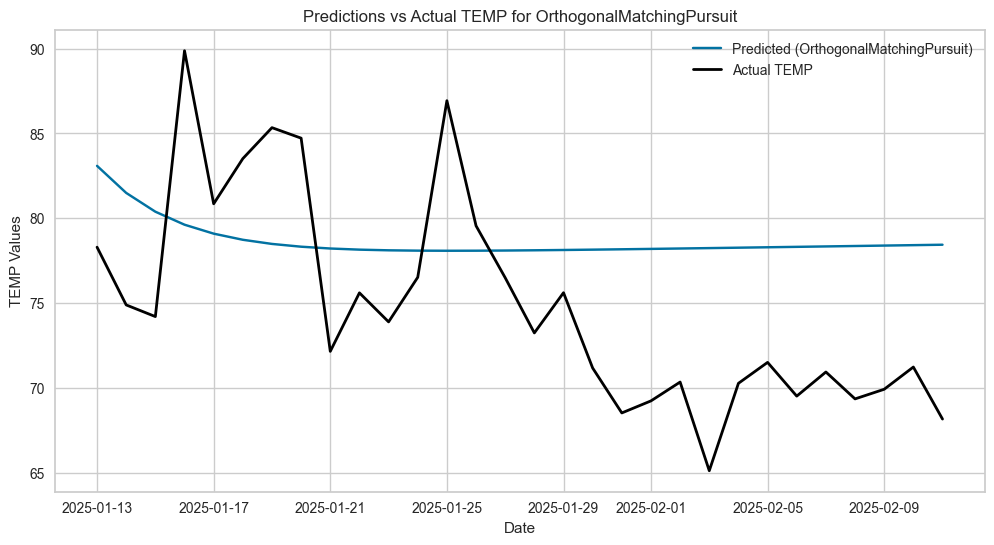

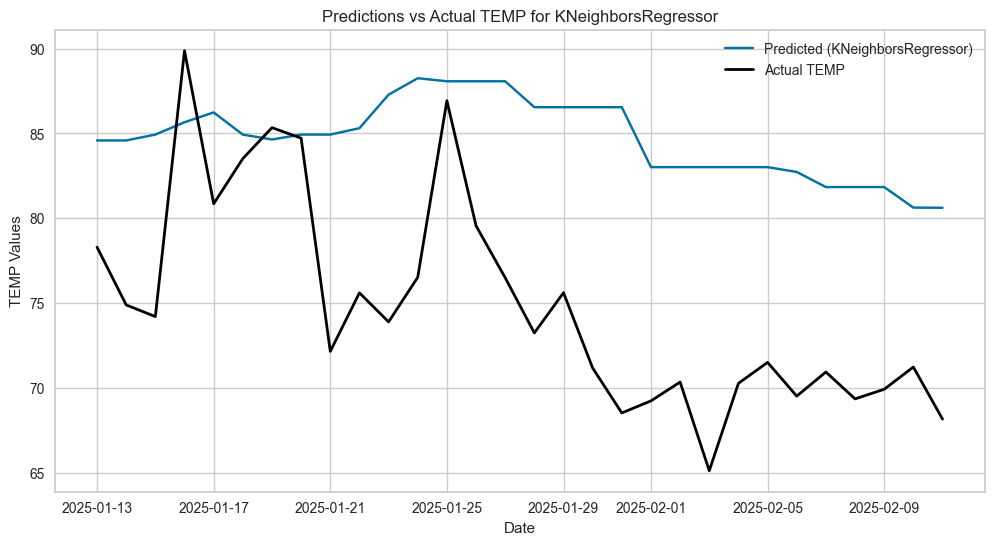

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        # เพิ่ม lag feature
        for i in range(1, lag_size + 1):
            test_1[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i).iloc[-1]

        # ลบค่า NaN ที่เกิดจากการ shift
        test_1 = test_1.dropna()

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'humidity'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'], real_data['humidity']], axis=1)
    result_plot.columns = ['Predictions', 'Actual TEMP']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['humidity'], label="Actual TEMP", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual TEMP for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('TEMP Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

In [62]:
# --------------------------------------------
# คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# --------------------------------------------
for model_name, result in result_dict.items():
    y_true = x.loc[start_date:end_date, 'humidity']  # ค่าจริง
    y_pred = result['prediction_label']

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = y_pred.dropna().index
    y_true = y_true.loc[valid_idx]
    y_pred = y_pred.loc[valid_idx]

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


📊 Model Performance Metrics:
Model: BayesianRidge
R² Score: 0.4417
Mean Absolute Error (MAE): 3.9650
Root Mean Squared Error (RMSE): 4.5868
Mean Absolute Percentage Error (MAPE): 5.42%
Accuracy: 94.58%
--------------------------------------------------

📊 Model Performance Metrics:
Model: Ridge
R² Score: 0.4642
Mean Absolute Error (MAE): 3.8687
Root Mean Squared Error (RMSE): 4.4938
Mean Absolute Percentage Error (MAPE): 5.27%
Accuracy: 94.73%
--------------------------------------------------

📊 Model Performance Metrics:
Model: LinearRegression
R² Score: 0.4653
Mean Absolute Error (MAE): 3.8569
Root Mean Squared Error (RMSE): 4.4888
Mean Absolute Percentage Error (MAPE): 5.26%
Accuracy: 94.74%
--------------------------------------------------

📊 Model Performance Metrics:
Model: ExtraTreesRegressor
R² Score: -1.6806
Mean Absolute Error (MAE): 9.2224
Root Mean Squared Error (RMSE): 10.0510
Mean Absolute Percentage Error (MAPE): 12.77%
Accuracy: 87.23%
-------------------------------